## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [ ]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [ ]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [ ]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [ ]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [ ]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

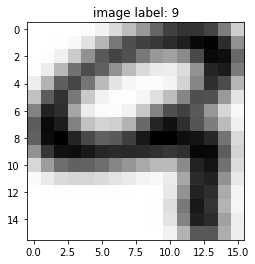

In [ ]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

In [ ]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h = F.relu(self.l1(inputs))
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

## Train your Model

In [ ]:
# Create the model: 
model = Model().to(device)

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, dataset_val=None, mode_2d = False):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    if dataset_val:
      val_error = []
      val_loader = DataLoader(dataset_val, batch_size, shuffle=True, drop_last=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              y_pre = model(images.view(batch_size, -1)) 
              #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
              y_pre = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if dataset_val:
          model.train(False)
          epoch_average_loss_val = 0.0
          for (images, labels) in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              y_pre = model(images.view(batch_size, -1)) 
              #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
              y_pre = model(images)
            labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            loss = criterion(y_pre, labels_one_hot)
            epoch_average_loss_val += loss.item() * batch_size / len(dataset_val)
          val_error.append(epoch_average_loss_val)
          print('Epoch [{}/{}], Training Loss: {:.4f} Validation Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss, epoch_average_loss_val))
        else:
          print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error, val_error

In [ ]:
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set)

Epoch [1/30], Training Loss: 0.0848 Validation Loss: 0.0791
Epoch [2/30], Training Loss: 0.0719 Validation Loss: 0.0654
Epoch [3/30], Training Loss: 0.0583 Validation Loss: 0.0516
Epoch [4/30], Training Loss: 0.0450 Validation Loss: 0.0388
Epoch [5/30], Training Loss: 0.0334 Validation Loss: 0.0288
Epoch [6/30], Training Loss: 0.0249 Validation Loss: 0.0225
Epoch [7/30], Training Loss: 0.0198 Validation Loss: 0.0189
Epoch [8/30], Training Loss: 0.0168 Validation Loss: 0.0166
Epoch [9/30], Training Loss: 0.0149 Validation Loss: 0.0150
Epoch [10/30], Training Loss: 0.0136 Validation Loss: 0.0139
Epoch [11/30], Training Loss: 0.0126 Validation Loss: 0.0132
Epoch [12/30], Training Loss: 0.0119 Validation Loss: 0.0125
Epoch [13/30], Training Loss: 0.0112 Validation Loss: 0.0121
Epoch [14/30], Training Loss: 0.0108 Validation Loss: 0.0117
Epoch [15/30], Training Loss: 0.0104 Validation Loss: 0.0113
Epoch [16/30], Training Loss: 0.0100 Validation Loss: 0.0110
Epoch [17/30], Training Loss: 0.0

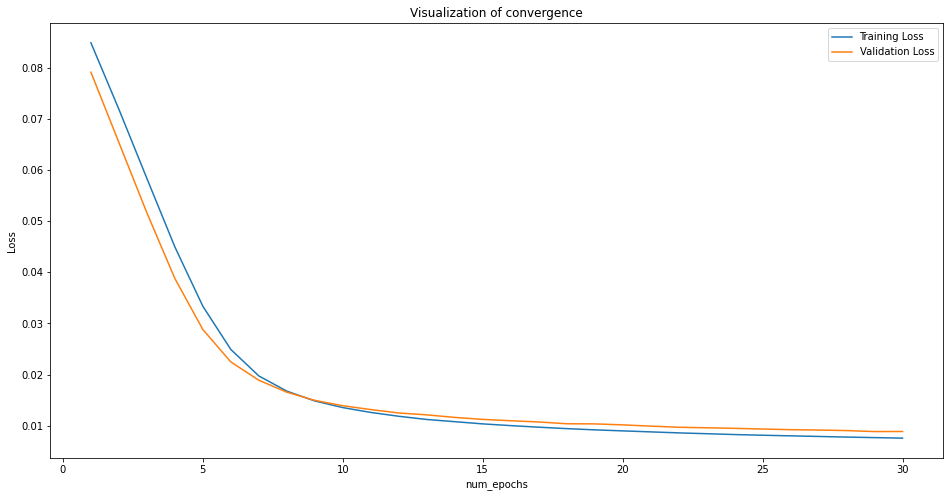

In [ ]:
# plot the training error wrt. the number of epochs: 
plt.figure(figsize=(16,8))
plt.plot(range(1, num_epochs+1), train_error, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_error, label="Validation Loss")
plt.legend()
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Visualization of convergence")
plt.show()

### Evaluate the Model on validation set

In [ ]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model, mode_2d = False):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [ ]:
accuracy(val_set, model)

Accuracy of the model : 94.58 %


Text(0.5, 1.0, 'Prediction label: 0')

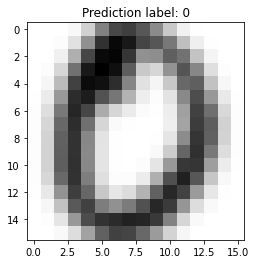

In [ ]:
val_index = 3

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16).to(device))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [ ]:
class MyModel(nn.Module):
    
    def __init__(self, mode_MSE = True):
        super(MyModel, self).__init__()
        self.mode_MSE = mode_MSE

        self.c1 = nn.Conv2d(1, 16, kernel_size=3, padding = 1)  #OUT : 16,16
        self.c1b = nn.Conv2d(16, 16, kernel_size=3, padding = 1)
        self.mp1 = nn.MaxPool2d((2,2))  #8,8
        self.bn1 = nn.BatchNorm2d(16)

        self.c2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)# 8,8
        self.mp2 = nn.MaxPool2d((2,2))#4,4
        self.bn2 = nn.BatchNorm2d(32)

        self.c3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)# 4,4
        self.mp3 = nn.MaxPool2d((2,2))#2,2
        self.bn3 = nn.BatchNorm2d(64)

        self.c4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)# 4,4
        self.mp4 = nn.MaxPool2d((2,2))#2,2

        self.l1 = nn.Linear(128,10)
        
        
    def forward(self, inputs):
        h = F.gelu(self.c1(inputs))
        h = F.gelu(self.c1b(h))
        h = self.mp1(h)
        h = self.bn1(h)

        h = F.gelu(self.c2(h))
        h = self.mp2(h)
        h = self.bn2(h)

        h = F.gelu(self.c3(h))
        h = self.mp3(h)
        h = self.bn3(h)

        h = F.gelu(self.c4(h))
        h = self.mp4(h)

        h = h.view(-1, 128)
        if self.mode_MSE:
          outputs = F.softmax(self.l1(h), dim=1) # Use softmax as the activation function for the last layer
        else:
          outputs=self.l1(h)
        return outputs

class Modelnlinears100neurons(nn.Module):
    
    def __init__(self, n_layers=2, layers_size=100):
        super(Modelnlinears100neurons, self).__init__()
        self.n_layers = n_layers

        self.linears = nn.ModuleList([nn.Linear(16*16, layers_size)])
        self.linears.extend([nn.Linear(layers_size, layers_size) for i in range(self.n_layers-1)])
        self.linears.append(nn.Linear(layers_size, 10))
        
    def forward(self, inputs):
        h = inputs
        for i in range(self.n_layers - 1):
          h = F.relu(self.linears[i](h))
        outputs = F.softmax(self.linears[-1](h), dim=1)# Use softmax as the activation function for the last layer
        
        return outputs

Epoch [1/30], Training Loss: 0.0279 Validation Loss: 0.0069
Epoch [2/30], Training Loss: 0.0046 Validation Loss: 0.0049
Epoch [3/30], Training Loss: 0.0026 Validation Loss: 0.0031
Epoch [4/30], Training Loss: 0.0018 Validation Loss: 0.0027
Epoch [5/30], Training Loss: 0.0013 Validation Loss: 0.0025
Epoch [6/30], Training Loss: 0.0009 Validation Loss: 0.0023
Epoch [7/30], Training Loss: 0.0007 Validation Loss: 0.0019
Epoch [8/30], Training Loss: 0.0005 Validation Loss: 0.0021
Epoch [9/30], Training Loss: 0.0004 Validation Loss: 0.0020
Epoch [10/30], Training Loss: 0.0003 Validation Loss: 0.0021
Epoch [11/30], Training Loss: 0.0002 Validation Loss: 0.0020
Epoch [12/30], Training Loss: 0.0002 Validation Loss: 0.0018
Epoch [13/30], Training Loss: 0.0002 Validation Loss: 0.0019
Epoch [14/30], Training Loss: 0.0002 Validation Loss: 0.0018
Epoch [15/30], Training Loss: 0.0002 Validation Loss: 0.0019
Epoch [16/30], Training Loss: 0.0002 Validation Loss: 0.0019
Epoch [17/30], Training Loss: 0.0

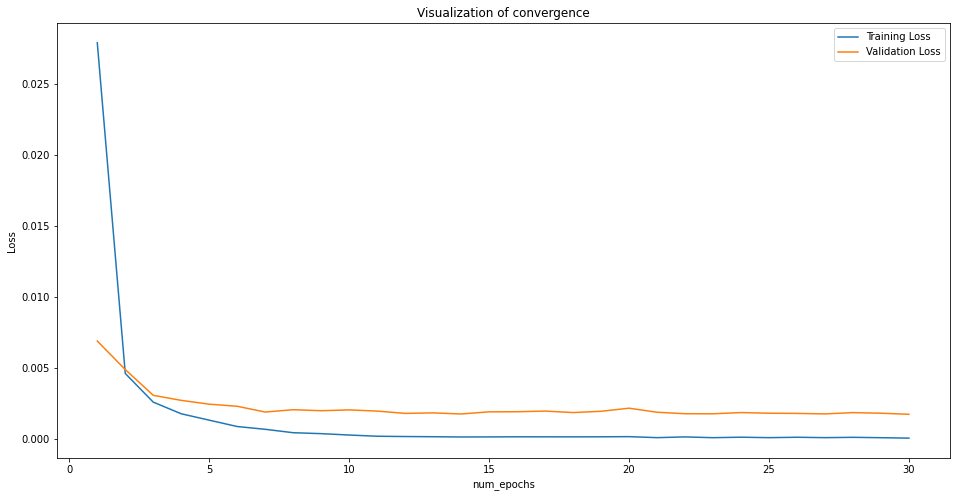

Accuracy of the model : 98.84 %


In [ ]:
# Create the model: 
model = MyModel()
model = model.to(device)

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 4

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, mode_2d = True)
# plot the training error wrt. the number of epochs: 
plt.figure(figsize=(16,8))
plt.plot(range(1, num_epochs+1), train_error, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_error, label="Validation Loss")
plt.legend()
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Visualization of convergence")
plt.show()
accuracy(val_set, model, True)

In [ ]:
model = Modelnlinears100neurons(n_layers = 10)
print(model)

Modelnlinears100neurons(
  (linears): ModuleList(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): Linear(in_features=100, out_features=10, bias=True)
  )
)


Epoch [1/30], Training Loss: 0.0899 Validation Loss: 0.0897
Epoch [2/30], Training Loss: 0.0896 Validation Loss: 0.0895
Epoch [3/30], Training Loss: 0.0894 Validation Loss: 0.0893
Epoch [4/30], Training Loss: 0.0893 Validation Loss: 0.0892
Epoch [5/30], Training Loss: 0.0891 Validation Loss: 0.0890
Epoch [6/30], Training Loss: 0.0888 Validation Loss: 0.0886
Epoch [7/30], Training Loss: 0.0880 Validation Loss: 0.0873
Epoch [8/30], Training Loss: 0.0845 Validation Loss: 0.0819
Epoch [9/30], Training Loss: 0.0793 Validation Loss: 0.0781
Epoch [10/30], Training Loss: 0.0767 Validation Loss: 0.0762
Epoch [11/30], Training Loss: 0.0747 Validation Loss: 0.0739
Epoch [12/30], Training Loss: 0.0708 Validation Loss: 0.0684
Epoch [13/30], Training Loss: 0.0651 Validation Loss: 0.0643
Epoch [14/30], Training Loss: 0.0622 Validation Loss: 0.0617
Epoch [15/30], Training Loss: 0.0594 Validation Loss: 0.0580
Epoch [16/30], Training Loss: 0.0549 Validation Loss: 0.0512
Epoch [17/30], Training Loss: 0.0

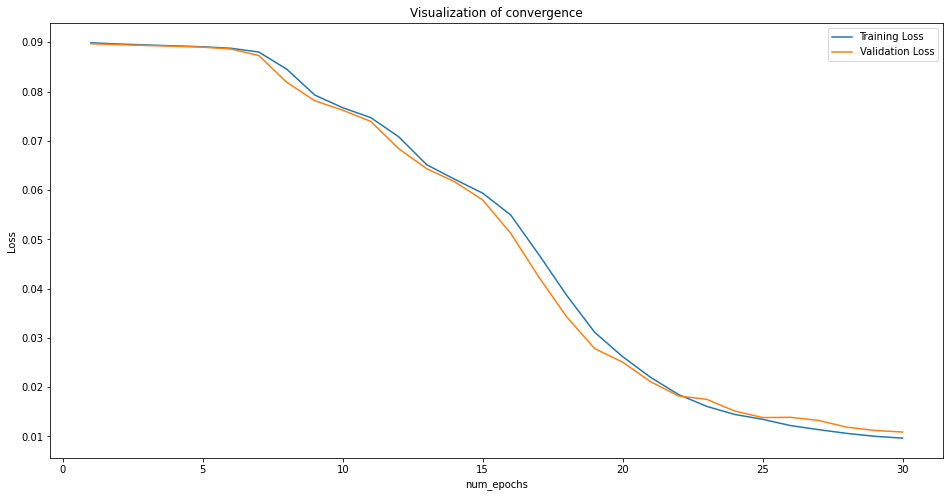

Accuracy of the model : 93.34 %


In [ ]:
# Create the model: 
model = Modelnlinears100neurons(n_layers = 5).to(device)

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set)
# plot the training error wrt. the number of epochs: 
plt.figure(figsize=(16,8))
plt.plot(range(1, num_epochs+1), train_error, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_error, label="Validation Loss")
plt.legend()
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Visualization of convergence")
plt.show()
accuracy(val_set, model)

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [ ]:

def get_accuracy(dataset, model, mode_2d = True):
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              images = images.view(-1,16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    return (100*correct.item()/ len(dataset))



# define a function for training
def train_time(tmax, batch_size, criterion, optimizer, model, dataset, dataset_val=None, mode_2d = False):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    if dataset_val:
      val_error = []
      val_loader = DataLoader(dataset_val, batch_size, shuffle=True, drop_last=True)

    epoch = 0
    t0 = time.time()
    t1 = time.time()

    while t1-t0<tmax:
        model.train()
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              y_pre = model(images.view(batch_size, -1)) 
              #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
              y_pre = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if dataset_val:
          model.train(False)
          epoch_average_loss_val = 0.0
          for (images, labels) in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              y_pre = model(images.view(batch_size, -1)) 
              #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
              y_pre = model(images)
            labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            loss = criterion(y_pre, labels_one_hot)
            epoch_average_loss_val += loss.item() * batch_size / len(dataset_val)
          val_error.append(epoch_average_loss_val)
          print('Epoch [{}/{}], Training Loss: {:.4f} Validation Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss, epoch_average_loss_val))
        else:
          print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
        t1 = time.time()
        epoch += 1
    return train_error, val_error

TRAINNG FOR BATCHSIZE =  1
Epoch [1/30], Training Loss: 0.0143 Validation Loss: 0.0115
Epoch [2/30], Training Loss: 0.0041 Validation Loss: 0.0149
TRAINNG FOR BATCHSIZE =  4
Epoch [1/30], Training Loss: 0.0265 Validation Loss: 0.0057
Epoch [2/30], Training Loss: 0.0046 Validation Loss: 0.0031
Epoch [3/30], Training Loss: 0.0025 Validation Loss: 0.0030
Epoch [4/30], Training Loss: 0.0018 Validation Loss: 0.0028
Epoch [5/30], Training Loss: 0.0011 Validation Loss: 0.0025
Epoch [6/30], Training Loss: 0.0008 Validation Loss: 0.0020
Epoch [7/30], Training Loss: 0.0006 Validation Loss: 0.0020
TRAINNG FOR BATCHSIZE =  8
Epoch [1/30], Training Loss: 0.0415 Validation Loss: 0.0121
Epoch [2/30], Training Loss: 0.0078 Validation Loss: 0.0055
Epoch [3/30], Training Loss: 0.0044 Validation Loss: 0.0042
Epoch [4/30], Training Loss: 0.0030 Validation Loss: 0.0034
Epoch [5/30], Training Loss: 0.0022 Validation Loss: 0.0028
Epoch [6/30], Training Loss: 0.0017 Validation Loss: 0.0029
Epoch [7/30], Train

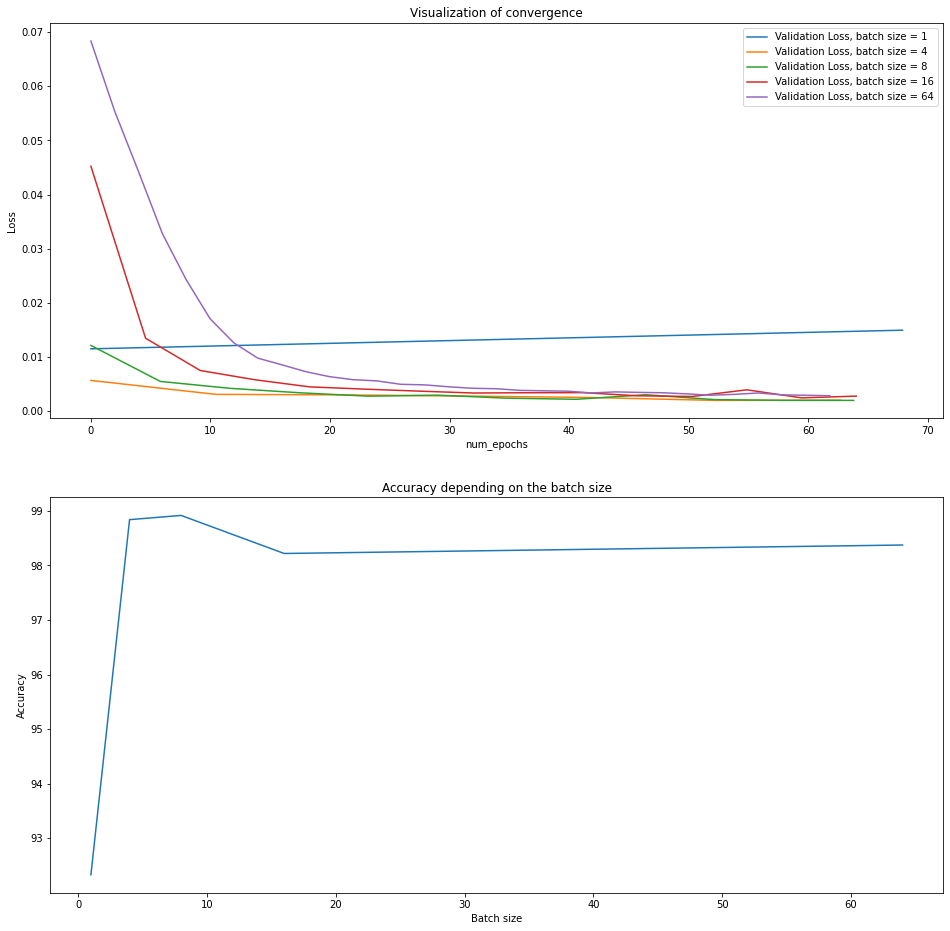

In [ ]:
# We will use only the convulotional model to test these parameters
import numpy as np
import time

def grid_batchsize(batchsizes):
  fig, axes = plt.subplots(2,1,figsize=(16,16))
  accs = []
  for bs in batchsizes:
    print('TRAINNG FOR BATCHSIZE = ', bs)
    model = MyModel()
    model.to(device)
    tmax = 60
    batch_size = bs
    criterion = nn.MSELoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    t0 = time.time()
    train_error, val_error = train_time(tmax, batch_size, criterion, optimizer, model, train_set, val_set, mode_2d=True)
    t1 = time.time()

    axes[0].plot(np.linspace(0,t1-t0, len(val_error)), val_error, label=f"Validation Loss, batch size = {batch_size}")
    accs.append(get_accuracy(val_set, model))
  axes[0].legend()
  axes[0].set_xlabel("num_epochs")
  axes[0].set_ylabel("Loss")
  axes[0].set_title("Visualization of convergence")

  axes[1].plot(batchsizes, accs)
  axes[1].set_xlabel("Batch size")
  axes[1].set_ylabel("Accuracy")
  axes[1].set_title("Accuracy depending on the batch size")

grid_batchsize([1,4,8,16,64])

In [ ]:
def grid_lrs(lrs, model_chosen, twoD = True):
  fig, axes = plt.subplots(2,1,figsize=(16,16))
  accs = []
  for lr in lrs:
    print('TRAINNG FOR LR = ', lr)
    # Create the model: 
    model = model_chosen()
    model.to(device)

    # Choose the hyperparameters for training: 
    tmax = 60
    batch_size = 4

    # Use mean squared loss function 
    criterion = nn.MSELoss()

    # Use SGD optimizer with a learning rate of 0.01
    # It is initialized on our model
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    t0 = time.time()
    train_error, val_error = train_time(tmax, batch_size, criterion, optimizer, model, train_set, val_set, twoD)
    t1 = time.time()
    # plot the training error wrt. the number of epochs: 
    axes[0].plot(np.linspace(0,t1-t0, len(val_error)), val_error, label=f"Validation Loss, lr = {lr}")
    accs.append(get_accuracy(val_set, model, twoD))
  axes[0].legend()
  axes[0].set_xlabel("num_epochs")
  axes[0].set_ylabel("Loss")
  axes[0].set_title("Visualization of convergence")

  axes[1].plot(lrs, accs)
  axes[1].set_xlabel("Learning rate")
  axes[1].set_xscale('log')
  axes[1].set_ylabel("Accuracy")
  axes[1].set_title("Accuracy depending on the learning rate")

TRAINNG FOR LR =  10
Epoch [1/30], Training Loss: 0.1365 Validation Loss: 0.1825
Epoch [2/30], Training Loss: 0.1819 Validation Loss: 0.1825
Epoch [3/30], Training Loss: 0.1819 Validation Loss: 0.1825
Epoch [4/30], Training Loss: 0.1819 Validation Loss: 0.1825
Epoch [5/30], Training Loss: 0.1819 Validation Loss: 0.1825
Epoch [6/30], Training Loss: 0.1819 Validation Loss: 0.1820
Epoch [7/30], Training Loss: 0.1845 Validation Loss: 0.1839
TRAINNG FOR LR =  1
Epoch [1/30], Training Loss: 0.0158 Validation Loss: 0.0147
Epoch [2/30], Training Loss: 0.0092 Validation Loss: 0.0065
Epoch [3/30], Training Loss: 0.0064 Validation Loss: 0.0070
Epoch [4/30], Training Loss: 0.0055 Validation Loss: 0.0040
Epoch [5/30], Training Loss: 0.0043 Validation Loss: 0.0040
Epoch [6/30], Training Loss: 0.0032 Validation Loss: 0.0044
Epoch [7/30], Training Loss: 0.0038 Validation Loss: 0.0042
TRAINNG FOR LR =  0.1
Epoch [1/30], Training Loss: 0.0260 Validation Loss: 0.0059
Epoch [2/30], Training Loss: 0.0042 V

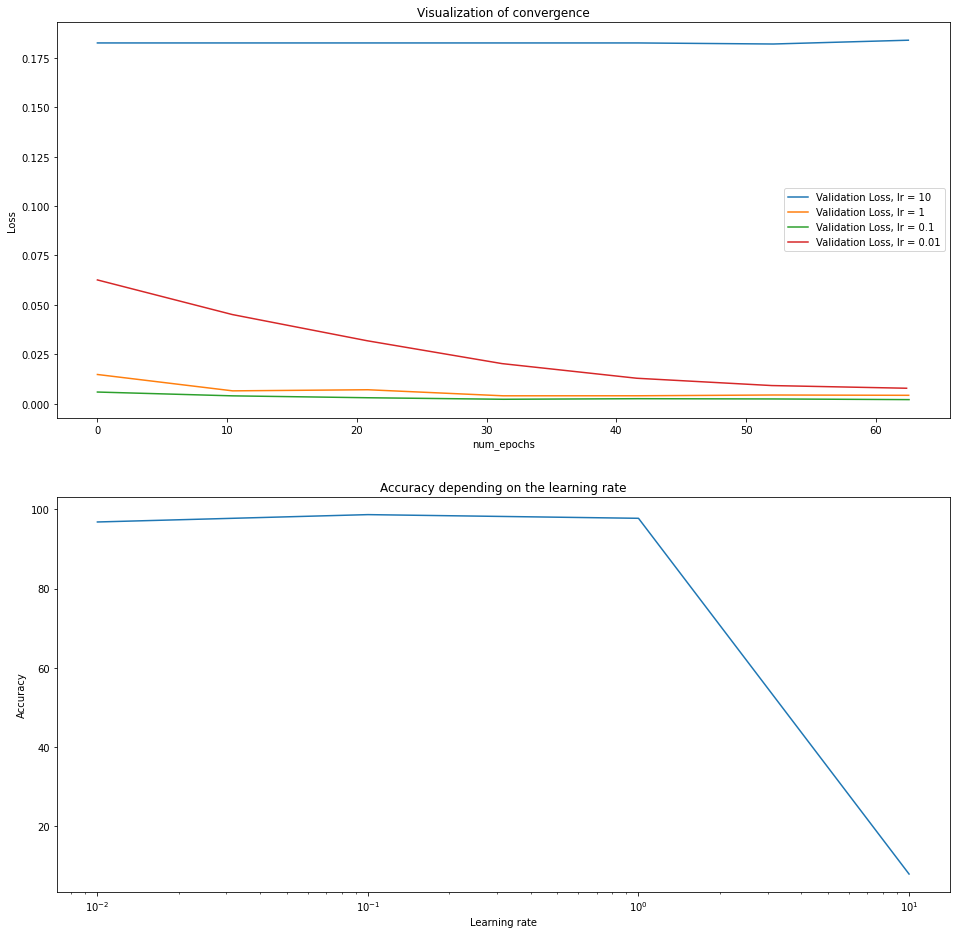

In [ ]:
grid_lrs([10,1,0.1,0.01], MyModel)

TRAINNG FOR LR =  1
Epoch [1/30], Training Loss: 0.0167 Validation Loss: 0.0113
Epoch [2/30], Training Loss: 0.0074 Validation Loss: 0.0069
Epoch [3/30], Training Loss: 0.0057 Validation Loss: 0.0059
Epoch [4/30], Training Loss: 0.0050 Validation Loss: 0.0065
Epoch [5/30], Training Loss: 0.0054 Validation Loss: 0.0033
Epoch [6/30], Training Loss: 0.0046 Validation Loss: 0.0072
Epoch [7/30], Training Loss: 0.0033 Validation Loss: 0.0032
TRAINNG FOR LR =  0.1
Epoch [1/30], Training Loss: 0.0274 Validation Loss: 0.0072
Epoch [2/30], Training Loss: 0.0050 Validation Loss: 0.0047
Epoch [3/30], Training Loss: 0.0029 Validation Loss: 0.0034
Epoch [4/30], Training Loss: 0.0020 Validation Loss: 0.0030
Epoch [5/30], Training Loss: 0.0015 Validation Loss: 0.0026
Epoch [6/30], Training Loss: 0.0010 Validation Loss: 0.0022
Epoch [7/30], Training Loss: 0.0006 Validation Loss: 0.0019
TRAINNG FOR LR =  0.01
Epoch [1/30], Training Loss: 0.0770 Validation Loss: 0.0624
Epoch [2/30], Training Loss: 0.0556

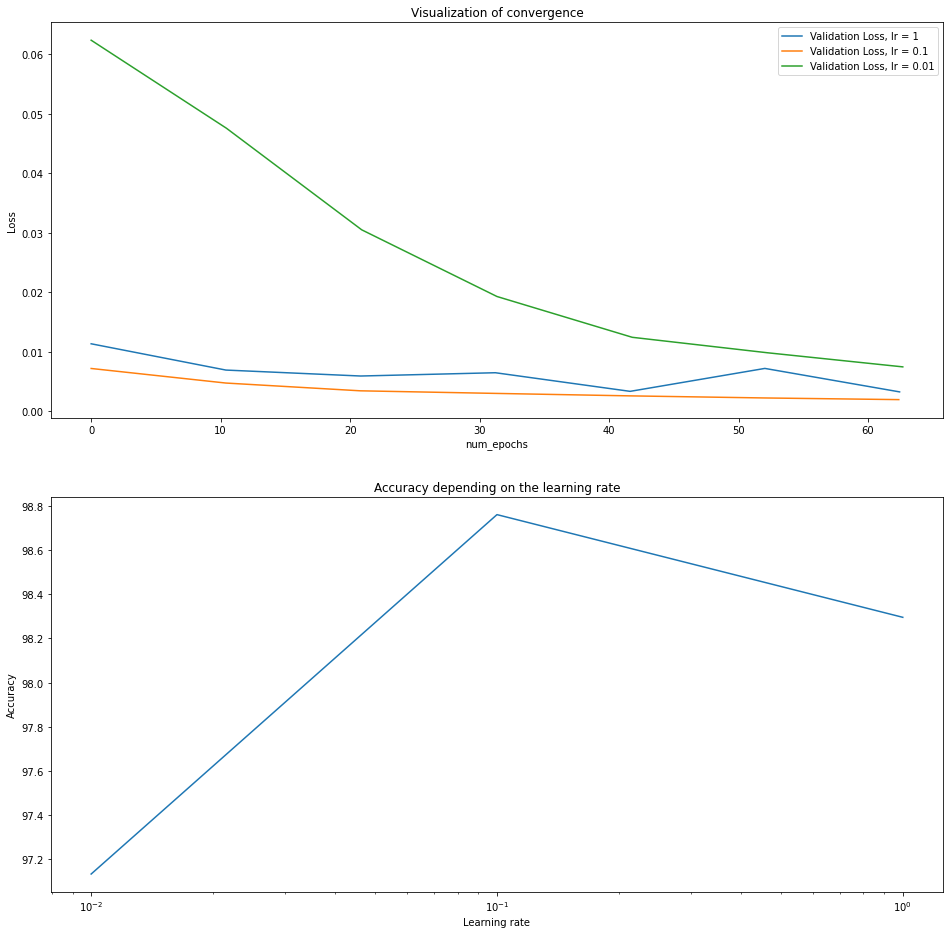

In [ ]:
grid_lrs([1,0.1,0.01], MyModel)

TRAINNG FOR LR =  10
Epoch [1/30], Training Loss: 0.0472 Validation Loss: 0.0283
Epoch [2/30], Training Loss: 0.0346 Validation Loss: 0.0268
Epoch [3/30], Training Loss: 0.0304 Validation Loss: 0.0450
Epoch [4/30], Training Loss: 0.0274 Validation Loss: 0.0248
Epoch [5/30], Training Loss: 0.0259 Validation Loss: 0.0214
Epoch [6/30], Training Loss: 0.0361 Validation Loss: 0.0235
Epoch [7/30], Training Loss: 0.0316 Validation Loss: 0.0193
Epoch [8/30], Training Loss: 0.0280 Validation Loss: 0.0357
Epoch [9/30], Training Loss: 0.0371 Validation Loss: 0.0443
Epoch [10/30], Training Loss: 0.0345 Validation Loss: 0.0279
Epoch [11/30], Training Loss: 0.0333 Validation Loss: 0.0302
Epoch [12/30], Training Loss: 0.0288 Validation Loss: 0.0258
Epoch [13/30], Training Loss: 0.0319 Validation Loss: 0.0351
Epoch [14/30], Training Loss: 0.0296 Validation Loss: 0.0481
Epoch [15/30], Training Loss: 0.0309 Validation Loss: 0.0295
Epoch [16/30], Training Loss: 0.0392 Validation Loss: 0.0377
Epoch [17/30

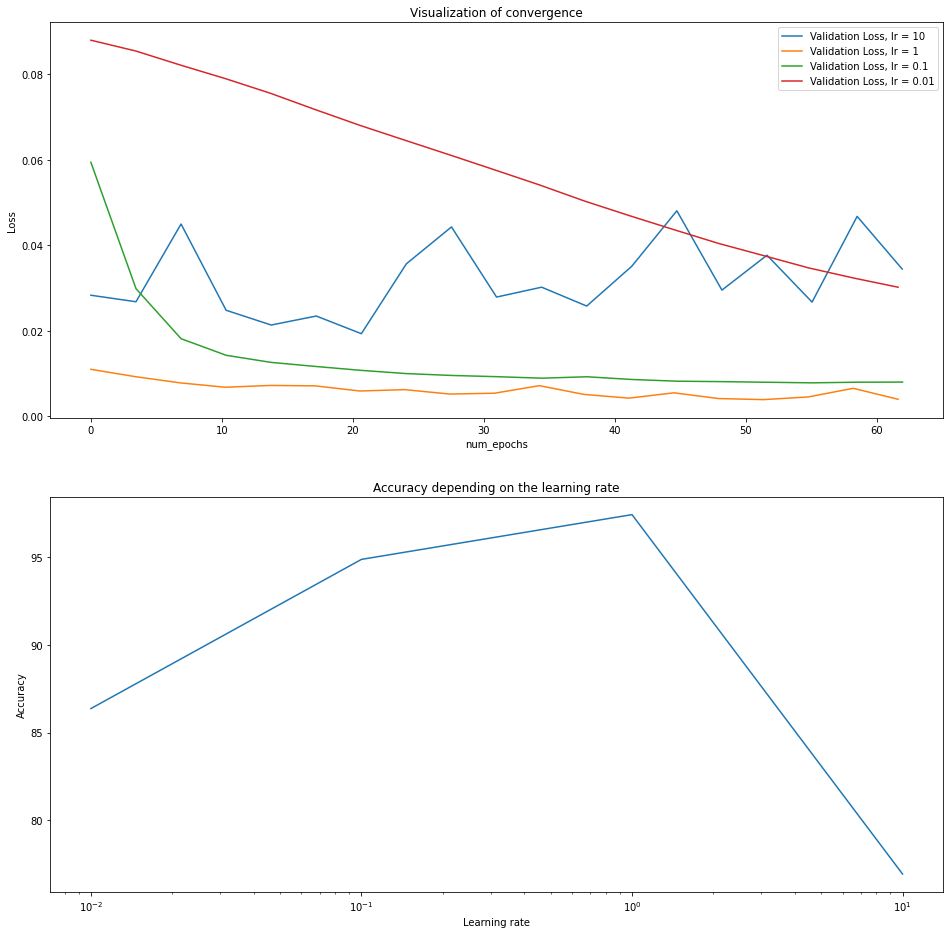

In [ ]:
grid_lrs([10,1,0.1,0.01], Modelnlinears100neurons, False)

Epoch [1/30], Training Loss: 0.0276 Validation Loss: 0.0068
Epoch [2/30], Training Loss: 0.0049 Validation Loss: 0.0036
Epoch [3/30], Training Loss: 0.0028 Validation Loss: 0.0030
Epoch [4/30], Training Loss: 0.0020 Validation Loss: 0.0025
Epoch [1/30], Training Loss: 0.0275 Validation Loss: 0.0152
Epoch [2/30], Training Loss: 0.0047 Validation Loss: 0.0041
Epoch [3/30], Training Loss: 0.0026 Validation Loss: 0.0028
Epoch [4/30], Training Loss: 0.0018 Validation Loss: 0.0024
Epoch [1/30], Training Loss: 0.0280 Validation Loss: 0.0065
Epoch [2/30], Training Loss: 0.0052 Validation Loss: 0.0044
Epoch [3/30], Training Loss: 0.0033 Validation Loss: 0.0030
Epoch [4/30], Training Loss: 0.0023 Validation Loss: 0.0035
Epoch [1/30], Training Loss: 0.0273 Validation Loss: 0.0070
Epoch [2/30], Training Loss: 0.0047 Validation Loss: 0.0041
Epoch [3/30], Training Loss: 0.0027 Validation Loss: 0.0039
Epoch [4/30], Training Loss: 0.0019 Validation Loss: 0.0038
Epoch [1/30], Training Loss: 0.0214 Vali

Text(0.5, 1.0, 'Visualization of convergence')

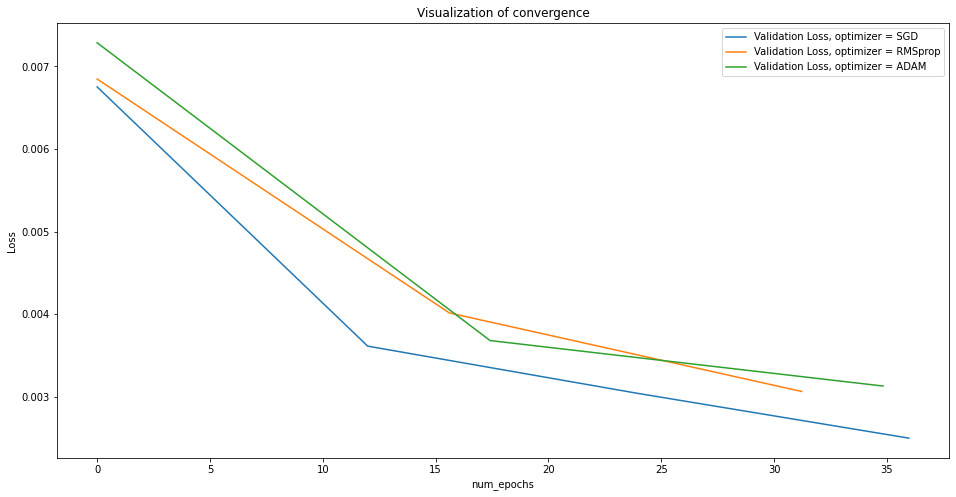

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(16,8))
accs = {
    'optimizer' : [],
    'accuracy' : []
}
optimizers = [
              (lambda model : torch.optim.SGD(model.parameters(), lr=0.1),"SGD"),
              (lambda model : torch.optim.RMSprop(model.parameters(), lr = 0.00008),'RMSprop'),
              (lambda model : torch.optim.Adam(model.parameters(), lr = 0.00008),"ADAM"),
              ]

for o,n in optimizers:
  for i in range(4):
    model = MyModel()
    model.to(device)
    tmax = 30
    batch_size = 4
    criterion = nn.MSELoss()

    optimizer = o(model)
    t0 = time.time()
    train_error, val_error = train_time(tmax, batch_size, criterion, optimizer, model, train_set, val_set, mode_2d=True)
    t1 = time.time()
    if i ==0:
      axes.plot(np.linspace(0,t1-t0, len(val_error)), val_error, label=f"Validation Loss, optimizer = {n}")
    accs['optimizer'].append(n)
    accs['accuracy'].append(get_accuracy(val_set, model))
axes.legend()
axes.set_xlabel("num_epochs")
axes.set_ylabel("Loss")
axes.set_title("Visualization of convergence")



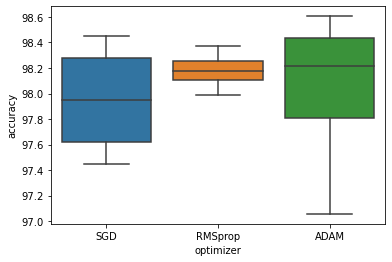

In [ ]:
 import pandas as pd
df = pd.DataFrame(accs)

import seaborn as sns

sns.boxplot(data = df, x = 'optimizer', y='accuracy')

Epoch [1/30], Training Loss: 0.0270 Validation Loss: 0.0077
Epoch [2/30], Training Loss: 0.0047 Validation Loss: 0.0036
Epoch [3/30], Training Loss: 0.0027 Validation Loss: 0.0030
Epoch [4/30], Training Loss: 0.0021 Validation Loss: 0.0029
Epoch [5/30], Training Loss: 0.0012 Validation Loss: 0.0022
Epoch [6/30], Training Loss: 0.0009 Validation Loss: 0.0019
Epoch [7/30], Training Loss: 0.0007 Validation Loss: 0.0019
Epoch [8/30], Training Loss: 0.0005 Validation Loss: 0.0017
Epoch [9/30], Training Loss: 0.0004 Validation Loss: 0.0019
Epoch [10/30], Training Loss: 0.0003 Validation Loss: 0.0017
Epoch [11/30], Training Loss: 0.0002 Validation Loss: 0.0019
Epoch [12/30], Training Loss: 0.0002 Validation Loss: 0.0020
Epoch [13/30], Training Loss: 0.0002 Validation Loss: 0.0018
Epoch [14/30], Training Loss: 0.0001 Validation Loss: 0.0019
Epoch [15/30], Training Loss: 0.0001 Validation Loss: 0.0019
Epoch [16/30], Training Loss: 0.0001 Validation Loss: 0.0017
Epoch [17/30], Training Loss: 0.0

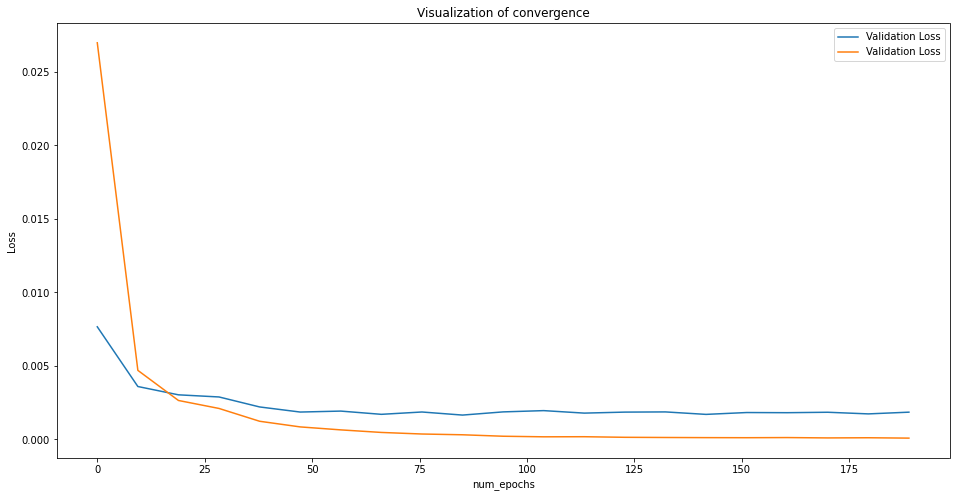

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(16,8))

model = MyModel()
model.to(device)
tmax = 180
batch_size = 4
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
t0 = time.time()
train_error, val_error = train_time(tmax, batch_size, criterion, optimizer, model, train_set, val_set, mode_2d=True)
t1 = time.time()

axes.plot(np.linspace(0,t1-t0, len(val_error)), val_error, label=f"Validation Loss")
axes.plot(np.linspace(0,t1-t0, len(val_error)), train_error, label=f"Validation Loss")

axes.legend()
axes.set_xlabel("num_epochs")
axes.set_ylabel("Loss")
axes.set_title("Visualization of convergence")

accuracy(val_set, model, True)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [ ]:
def train_time_cross_entropy(tmax, batch_size, criterion, optimizer, model, dataset, dataset_val=None, mode_2d = False):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    if dataset_val:
      val_error = []
      val_loader = DataLoader(dataset_val, batch_size, shuffle=True, drop_last=True)

    epoch = 0
    t0 = time.time()
    t1 = time.time()

    while t1-t0<tmax:
        model.train()
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              y_pre = model(images.view(batch_size, -1)) 
              #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
              y_pre = model(images)
            

           
            
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if dataset_val:
          model.train(False)
          epoch_average_loss_val = 0.0
          for (images, labels) in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            if not mode_2d:
              y_pre = model(images.view(batch_size, -1)) 
              #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
              y_pre = model(images)

            loss = criterion(y_pre, labels)
            epoch_average_loss_val += loss.item() * batch_size / len(dataset_val)
          val_error.append(epoch_average_loss_val)
          print('Epoch [{}/{}], Training Loss: {:.4f} Validation Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss, epoch_average_loss_val))
        else:
          print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
        t1 = time.time()
        epoch += 1
    return train_error, val_error


Epoch [1/30], Training Loss: 0.3399 Validation Loss: 0.1065
Epoch [2/30], Training Loss: 0.0737 Validation Loss: 0.0616
Epoch [3/30], Training Loss: 0.0429 Validation Loss: 0.0522
Epoch [4/30], Training Loss: 0.0271 Validation Loss: 0.0581
Epoch [5/30], Training Loss: 0.0141 Validation Loss: 0.0383
Epoch [6/30], Training Loss: 0.0111 Validation Loss: 0.0464
Epoch [7/30], Training Loss: 0.0091 Validation Loss: 0.0423
Epoch [8/30], Training Loss: 0.0073 Validation Loss: 0.0565
Epoch [9/30], Training Loss: 0.0075 Validation Loss: 0.0524
Epoch [10/30], Training Loss: 0.0044 Validation Loss: 0.0429
Epoch [11/30], Training Loss: 0.0036 Validation Loss: 0.0389
Epoch [12/30], Training Loss: 0.0028 Validation Loss: 0.0439
Epoch [13/30], Training Loss: 0.0027 Validation Loss: 0.0430
Epoch [14/30], Training Loss: 0.0021 Validation Loss: 0.0417
Epoch [15/30], Training Loss: 0.0026 Validation Loss: 0.0381
Epoch [16/30], Training Loss: 0.0023 Validation Loss: 0.0424
Epoch [17/30], Training Loss: 0.0

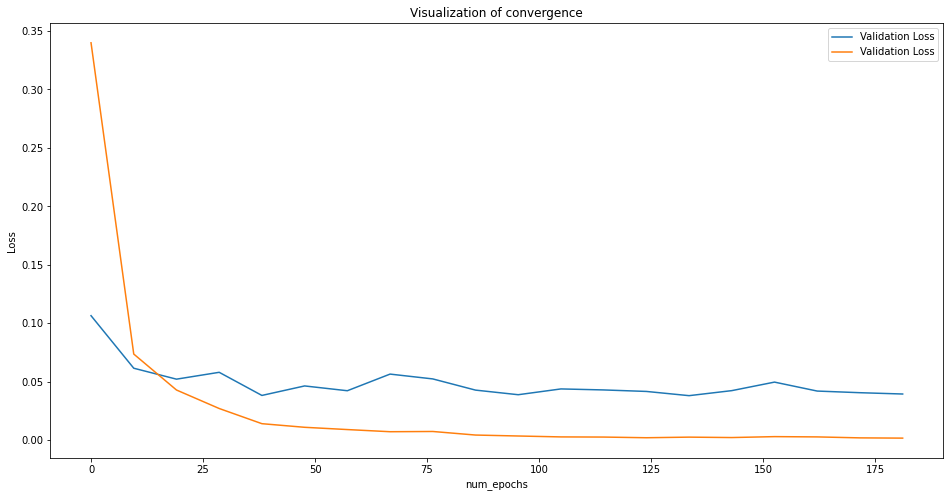

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(16,8))

model = MyModel(False)
model.to(device)
tmax = 180
batch_size = 4
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
t0 = time.time()
train_error, val_error = train_time(tmax, batch_size, criterion, optimizer, model, train_set, val_set, mode_2d=True)
t1 = time.time()

axes.plot(np.linspace(0,t1-t0, len(val_error)), val_error, label=f"Validation Loss")
axes.plot(np.linspace(0,t1-t0, len(val_error)), train_error, label=f"Validation Loss")

axes.legend()
axes.set_xlabel("num_epochs")
axes.set_ylabel("Loss")
axes.set_title("Visualization of convergence")

accuracy(val_set, model, True)

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [ ]:
accuracy(test_set, model, True)

Accuracy of the model : 96.76 %
